In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset #load_dataset from Huggingface
from scipy import stats
from scipy.stats import rankdata, spearmanr, pearsonr
import statsmodels.stats.proportion as smp

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams['font.family'] = 'Palatino'

In [3]:
LANG_DICT = {'afrikaans':'afr_Latn' ,
'english': 'eng_Latn',
'amharic':'amh_Ethi' ,
'armenian':'hye_Armn' ,
'assamese':'asm_Beng' ,
'basque':'eus_Latn' ,
'bengali':'ben_Beng' ,
'bulgarian':'bul_Cyrl' ,
'burmese':'mya_Mymr' ,
'catalan':'cat_Latn' ,
'central kurdish':'ckb_Arab' ,
'croatian': 'hrv_Latn',
'dutch': 'nld_Latn',
'xhosa': 'xho_Latn',
'macedonian': 'mkd_Cyrl',
'czech':'ces_Latn' ,
'danish':'dan_Latn' ,
'eastern panjabi':'pan_Guru' ,
'egyptian arabic':'arz_Arab' ,
'estonian':'est_Latn' ,
'finnish':'fin_Latn' ,
'french':'fra_Latn' ,
'georgian':'kat_Geor' ,
'german':'deu_Latn' ,
'greek':'ell_Grek' ,
'gujarati':'guj_Gujr' ,
'hausa':'hau_Latn' ,
'hebrew':'heb_Hebr' ,
'hindi':'hin_Deva' ,
'hungarian':'hun_Latn' ,
'icelandic':'isl_Latn' ,
'indonesian':'ind_Latn' ,
'italian':'ita_Latn' ,
'japanese':'jpn_Jpan' ,
'javanese':'jav_Latn' ,
'kannada':'kan_Knda' ,
'kazakh':'kaz_Cyrl' ,
'khmer':'khm_Khmr' ,
'korean':'kor_Hang' ,
'kyrgyz':'kir_Cyrl' ,
'lao':'lao_Laoo' ,
'lithuanian':'lit_Latn' ,
'malayalam':'mal_Mlym' ,
'marathi':'mar_Deva' ,
'mesopotamian arabic':'acm_Arab' ,
'modern standard arabic':'arb_Arab' ,
'moroccan arabic':'ary_arab' ,
'najdi arabic':'ars_Arab' ,
'nepali':'npi_Deva' ,
'north azerbaijani':'azj_Latn' ,
'north levantine arabic':'apc_Arab' ,
'northern uzbek':'uzn_Latn' ,
'norwegian bokmal':'nob_Latn' ,
'odia':'ory_Orya' ,
'polish':'pol_Latn' ,
'portuguese':'por_Latn' ,
'romanian':'ron_Latn' ,
'russian':'rus_Cyrl' ,
'serbian':'srp_Cyrl' ,
'simplified chinese':'zho_Hans' ,
'sindhi':'snd_Arab' ,
'sinhala':'sin_Sinh' ,
'slovak':'slk_Latn' ,
'slovenian':'slv_Latn' ,
'somali':'som_Latn' ,
'southern pashto':'pbt_Arab' ,
'spanish':'spa_Latn' ,
'standard latvian':'lvs_Latn' ,
'standard malay':'zsm_Latn' ,
'sundanese':'sun_Latn' ,
'swahili':'swh_Latn' ,
'swedish':'swe_Latn' ,
'tamil':'tam_Taml' ,
'telugu':'tel_Telu' ,
'thai':'tha_Thai' ,
'tosk albanian':'als_Latn' ,
'traditional chinese':'zho_Hant' ,
'turkish':'tur_Latn' ,
'ukrainian':'ukr_Cyrl' ,
'urdu':'urd_Arab' ,
'vietnamese':'vie_Latn' ,
'western persian':'pes_Arab'}

LANGUAGE=[k for k,v in LANG_DICT.items()]
LANGUAGE_wo_ENGLISH = [k for k,v in LANG_DICT.items() if k!='english']

In [4]:
LR_LANG = ['acm_Arab',
'amh_Ethi',
'apc_Arab',
'ars_Arab',
'ary_Arab',
'arz_Arab',
'asm_Beng',
'azj_Latn',
'ckb_Arab',
'guj_Gujr',
'hau_Latn',
'hye_Armn',
'jav_Latn',
'kan_Knda',
'kat_Geor',
'khm_Khmr',
'kir_Cyrl',
'lao_Laoo',
'mal_Mlym',
'mar_Deva',
'mya_Mymr',
'nob_Latn',
'npi_Deva',
'ory_Orya',
'pan_Guru',
'pbt_Arab',
'sin_Sinh',
'snd_Arab',
'som_Latn',
'srp_Cyrl',
'sun_Latn',
'tam_Taml',
'tel_Telu',
'urd_Arab',
'uzn_Latn']

In [5]:
HR_LANG = ['afr_Latn',
'als_Latn',
'arb_Arab',
'ben_Beng',
'bul_Cyrl',
'cat_Latn',
'ces_Latn',
'dan_Latn',
'deu_Latn',
'ell_Grek',
'est_Latn',
'eus_Latn',
'fin_Latn',
'fra_Latn',
'heb_Hebr',
'hin_Deva',
'hrv_Latn',
'hun_Latn',
'ind_Latn',
'isl_Latn',
'ita_Latn',
'jpn_Jpan',
'kaz_Cyrl',
'kor_Hang',
'lit_Latn',
'lvs_Latn',
'mkd_Cyrl',
'nld_Latn',
'pes_Arab',
'pol_Latn',
'por_Latn',
'ron_Latn',
'rus_Cyrl',
'slk_Latn',
'slv_Latn',
'spa_Latn',
'swe_Latn',
'swh_Latn',
'tha_Thai',
'tur_Latn',
'ukr_Cyrl',
'vie_Latn',
'xho_Latn',
'zho_Hans',
'zho_Hant',
'zsm_Latn']

In [6]:
def get_accuracy_outputs(lang, dataset='belebele', model='Llama3.1'):
    model_dict = {'Llama3.1': 'meta-llama__Llama-3.1-8B'}
    lang_code = LANG_DICT[lang]
    model_code = model_dict[model]
    #hf = load_dataset("Kartik221/Belebele_test", lang_code)
    #label = hf['test']['correct_answer_num']
    #answer = []
    #for i in range(len(label)):
        #answer.append(label[i])

    accuracy_data_path = f'../../accuracy_outputs/{model}/{dataset}_5shot/{lang_code}/'

    # Find the .jsonl file in the directory
    jsonl_file = [f for f in os.listdir(accuracy_data_path) if f.endswith('.jsonl')][0]
    file_path = os.path.join(accuracy_data_path, jsonl_file)
    # Read the jsonl file line by line
    accuracy_results = []
    with open(file_path, 'r') as f:
        for line in f:
            accuracy_results.append(json.loads(line))

    resps = [item['resps'] for item in accuracy_results]
    accuracy = [item['acc'] for item in accuracy_results]

    score_diff = []
    for i in range(len(accuracy)):
        logprob = [float(resps[i][0][0][0]), float(resps[i][1][0][0]), float(resps[i][2][0][0]), float(resps[i][3][0][0])]
        model_pred_idx = np.argmax(logprob)
        pred_logprob = logprob[model_pred_idx]
        next_best_logprob = max([logprob[i] for i in range(3) if i!=model_pred_idx])    
        score_diff.append(pred_logprob - next_best_logprob)
    return score_diff, accuracy


In [7]:
def compute_confusion_matrix(correct_eng, incorrect_eng, correct_lang, incorrect_lang):
    TP = len(set(correct_eng) & set(correct_lang))
    FN = len(set(incorrect_eng) & set(correct_lang))
    FP = len(set(correct_eng) & set(incorrect_lang))
    TN = len(set(incorrect_eng) & set(incorrect_lang))
    
    return np.array([[TP, FN], [FP, TN]])

In [8]:
acc_dict = defaultdict(dict)
score_diff_dict = defaultdict(dict)

conf_matrices = defaultdict(dict)

score_diff_dict['english'], acc_dict['english'] = get_accuracy_outputs('english', 'belebele', 'Llama3.1')

for lang in LANGUAGE:
    score_diff_dict[lang],acc_dict[lang]  = get_accuracy_outputs(lang, 'belebele', 'Llama3.1')
    ''' 
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
       
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]

    # Example language data (Replace with actual lists)
    conf_matrices[lang] = compute_confusion_matrix(correct_id_eng, incorrect_id_eng, correct_id_lang, incorrect_id_lang)
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))

# Plot multiple confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

for ax, (lang, matrix) in zip(axes.flat, conf_matrices.items()):
    
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Correct_Eng", "Incorrect_Eng"], 
                yticklabels=["Correct_Lang", "Incorrect_Lang"], ax=ax)
    ax.set_title(lang)

    plt.tight_layout()
plt.show()   
    
    '''
    


In [9]:
def plot_DALI(dataset, lang, model, mode):
    lang_code = LANG_DICT[lang]
    if mode == 'DALI':
        DAS_path = f'../../alignment_outputs/{model}/{dataset}_dali/DALI_{lang_code}_lasttoken.json'
    if mode == 'DALIStrong':
        DAS_path = f'../../alignment_outputs/{model}/{dataset}_dali_strong/DALI_{lang_code}_lasttoken.json'

    if mode == 'MEXAFlores':
        DAS_path = f'../../alignment_outputs/{model}/flores_mexa/{lang_code}.json'
    if mode == 'MEXATask':
        DAS_path = f'../../alignment_outputs/{model}/{dataset}_mexa/{lang_code}.json'
    with open(DAS_path) as f:
        lang_DAS = json.load(f)
    return lang_DAS

In [10]:
def load_translation_agg(dataset, model, field='flores_passage'):
    if dataset == 'flores':
        entoxxpath = f'../../translation_outputs/{model}/{dataset}_100/sentence/entoxx_{model}_{dataset}_COMET.json'
        xxtoenpath = f'../../translation_outputs/{model}/{dataset}_100/sentence/xxtoen_{model}_{dataset}_COMET.json'
        #list_of_languages = ['modern standard arabic', 'spanish', 'basque', 'hindi', 'indonesian', 'burmese', 'russian', 'telugu', 'simplified chinese', 'swahili']
        #lang_key = {'modern standard arabic': 'arabic', 'spanish': 'spanish', 'basque': 'basque', 'hindi': 'hindi', 'indonesian': 'indonesian', 'burmese': 'burmese', 'russian': 'russian', 'telugu': 'telugu', 'simplified chinese': 'chinese', 'swahili': 'swahili'}

        with open(entoxxpath) as f:
            entoxx_COMET = json.load(f)
    
        with open(xxtoenpath) as f:
            xxtoen_COMET = json.load(f)
        
        entoxx_COMET_filtered = {}
        xxtoen_COMET_filtered = {}
        for k,v in entoxx_COMET.items():
            if k in LANG_DICT.keys():
                entoxx_COMET_filtered[k] = v[0]
        for k,v in xxtoen_COMET.items():
            if k in LANG_DICT.keys():
                xxtoen_COMET_filtered[k] = v[0]

    if dataset == 'belebele':
        entoxxpath = f'../../translation_outputs/{model}/{dataset}/{field}/entoxx_{model}_{dataset}_COMET.json'
        xxtoenpath = f'../../translation_outputs/{model}/{dataset}/{field}/xxtoen_{model}_{dataset}_COMET.json'

        with open(entoxxpath) as f:
            entoxx_COMET = json.load(f)
        with open(xxtoenpath) as f:
            xxtoen_COMET = json.load(f)
        entoxx_COMET_filtered = {}
        xxtoen_COMET_filtered = {}

        for k,v in entoxx_COMET.items():
            entoxx_COMET_filtered[k] = v[0]
        for k,v in xxtoen_COMET.items():
            xxtoen_COMET_filtered[k] = v[0]           
    return entoxx_COMET_filtered, xxtoen_COMET_filtered


In [11]:
# Calculate accuracies and get DAS scores for each language
def plot_alignment_by_layers(mode):
    accuracies = {}
    max_das_scores = {}
    mean_das_scores={}
    all_das_avgs = {}

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.rcParams['font.family'] = 'Palatino'


    for lang in LANGUAGE_wo_ENGLISH:
        # Calculate accuracy
        accuracies[lang] = (sum(acc_dict[lang])/len(acc_dict[lang])) 
        # Get DAS data for this language
        lang_DAS = plot_DALI('belebele', lang, 'Llama3.1', mode)
        
        if mode == 'DALI' or mode == 'DALIStrong':
            lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                        for outer_k, inner_v in lang_DAS.items()}
            layer_avgs = []
            for layer in range(32):
                layer_scores = [lang_DAS[sample][layer] for sample in lang_DAS.keys()]
                layer_avgs.append(np.mean(layer_scores))

            all_das_avgs[lang] = layer_avgs
            max_das_scores[lang] = np.max(all_das_avgs[lang])
            mean_das_scores[lang] = np.mean(all_das_avgs[lang])
            ax.plot(range(32), layer_avgs, 
                label=f'{lang.capitalize()}', 
                marker='o', markersize=2)


            
        else: 
            lang_DAS = {int(k): v for k,v in lang_DAS.items()}
            layer_avgs = []
            for layer in range(32):
                layer_avgs.append(np.mean(lang_DAS[layer]))      
            all_das_avgs[lang] = layer_avgs
            max_das_scores[lang] = np.max(all_das_avgs[lang])
            mean_das_scores[lang] = np.mean(all_das_avgs[lang])
            

            ax.plot(range(32), layer_avgs, 
                label=f'{lang.capitalize()}', 
                marker='o', markersize=2)

    ax.set_xlabel('Layer')
    ax.tick_params(axis='both',labelsize=14)
    ax.set_ylabel(f'{mode}')
    #ax.set_title('DALI Scores Across Layers (story completion)')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0,1)
    #plt.tight_layout()
    #plt.show()
    return accuracies, max_das_scores, mean_das_scores

In [12]:
entoxx_flores_agg, xxtoen_flores_agg = load_translation_agg('flores', 'Llama3.1', field=None)
entoxx_dataset_agg, xxtoen_dataset_agg = load_translation_agg('belebele', 'Llama3.1')

In [13]:
def load_translation_sample(dataset, model, field):
    entoxxpath = f'../../translation_outputs/{model}/{dataset}_100/{field}/entoxx_{model}_{dataset}_COMET_sample.json'
    xxtoenpath = f'../../translation_outputs/{model}/{dataset}_100/{field}/xxtoen_{model}_{dataset}_COMET_sample.json'

    with open(entoxxpath) as f:
        entoxx_COMET_sample = json.load(f)
    with open(xxtoenpath) as f:
        xxtoen_COMET_sample = json.load(f)

    return entoxx_COMET_sample, xxtoen_COMET_sample

In [ ]:
def plot_ranked_correlation(entoxx_dataset_agg, 
                            xxtoen_dataset_agg, 
                            entoxx_flores_agg, 
                            xxtoen_flores_agg,
                            accuracies,
                            dali,
                            dali_strong,
                            mexa_flores,
                            mexa_dataset,
                            mode = "translation-accuracy",
                            subgroup="All"):
    

    if subgroup=="All":
        lang_list = LANGUAGE_wo_ENGLISH
    if subgroup=="HR":
        lang_list = [k for k,v in LANG_DICT.items() if v in HR_LANG]
    if subgroup=="LR":
        lang_list = [k for k,v in LANG_DICT.items() if v in LR_LANG]
    

    accuracies_rank = rankdata([accuracies[lang] for lang in lang_list])
    entoxx_flores_rank = rankdata([entoxx_flores_agg[lang] for lang in lang_list])
    xxtoen_flores_rank = rankdata([xxtoen_flores_agg[lang] for lang in lang_list])
    entoxx_dataset_rank = rankdata([entoxx_dataset_agg[lang] for lang in lang_list])
    xxtoen_dataset_rank = rankdata([xxtoen_dataset_agg[lang] for lang in lang_list])
    dali_rank = rankdata([dali[lang] for lang in lang_list])
    dali_strong_rank = rankdata([dali_strong[lang] for lang in lang_list])
    mexa_flores_rank = rankdata([mexa_flores[lang] for lang in lang_list])
    mexa_dataset_rank = rankdata([mexa_dataset[lang] for lang in lang_list])

    if mode == "translation-accuracy":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        corr_entoxx_flores_acc, _ = spearmanr(entoxx_flores_rank, accuracies_rank)
        corr_xxtoen_flores_acc, _ = spearmanr(xxtoen_flores_rank, accuracies_rank)
        corr_entoxx_dataset_acc, _ = spearmanr(entoxx_dataset_rank, accuracies_rank)
        corr_xxtoen_dataset_acc, _ = spearmanr(xxtoen_dataset_rank, accuracies_rank)

        slope_entoxx_flores_acc, b_entoxx_flores_acc = np.polyfit(entoxx_dataset_rank, accuracies_rank, 1)
        slope_xxtoen_flores_acc, b_xxtoen_flores_acc = np.polyfit(xxtoen_dataset_rank, accuracies_rank, 1)
        slope_entoxx_dataset_acc, b_entoxx_dataset_acc = np.polyfit(entoxx_dataset_rank, accuracies_rank, 1)
        slope_xxtoen_dataset_acc, b_xxtoen_dataset_acc = np.polyfit(xxtoen_dataset_rank, accuracies_rank, 1)

        axes[0][0].scatter(entoxx_flores_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[0][0].plot(entoxx_flores_rank, np.array(entoxx_flores_rank) * slope_entoxx_flores_acc + b_entoxx_flores_acc, color='red', label=f'Linear fit: y={slope_entoxx_flores_acc:.2f}x+{b_entoxx_flores_acc:.2f}')
        axes[0][0].text(min(entoxx_flores_rank)+1, max(accuracies_rank)-4., f'Spearman r: {corr_entoxx_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('COMET Flores (En->XX)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'En->XX Flores COMET vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(xxtoen_flores_rank, accuracies_rank, alpha=0.7, color='teal')
        axes[0][1].plot(xxtoen_flores_rank, np.array(xxtoen_flores_rank) * slope_xxtoen_flores_acc + b_xxtoen_flores_acc, color='red', label=f'Linear fit: y={slope_xxtoen_flores_acc:.2f}x+{b_xxtoen_flores_acc:.2f}')
        axes[0][1].text(min(xxtoen_flores_rank)+1, max(accuracies_rank)-4, f'Spearman r: {corr_xxtoen_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('COMET Flores (XX->En)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'XX->En Flores COMET vs Accuracy')
        #axes[0][1].set_xlim(0,1)
        #axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(entoxx_dataset_rank, accuracies_rank, alpha=0.7, color='brown')
        axes[1][0].plot(entoxx_dataset_rank, np.array(entoxx_dataset_rank) * slope_entoxx_dataset_acc + b_entoxx_dataset_acc, color='red', label=f'Linear fit: y={slope_entoxx_dataset_acc:.2f}x+{b_entoxx_dataset_acc:.2f}')
        axes[1][0].text(min(entoxx_dataset_rank)+1, max(accuracies_rank)-4, f'Spearman r: {corr_entoxx_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('COMET Dataset (En->XX)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'En->XX Dataset COMET vs Accuracy')
        #axes[1][0].set_xlim(0,1)
        #axes[1][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(xxtoen_dataset_rank, accuracies_rank, alpha=0.7, color='green')
        axes[1][1].plot(xxtoen_dataset_rank, np.array(xxtoen_dataset_rank) * slope_xxtoen_dataset_acc + b_xxtoen_dataset_acc, color='red', label=f'Linear fit: y={slope_xxtoen_dataset_acc:.2f}x+{b_xxtoen_dataset_acc:.2f}')
        axes[1][1].text(min(xxtoen_dataset_rank)+1, max(accuracies_rank)-4, f'Spearman r: {corr_xxtoen_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('COMET Dataset (XX->En)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'XX->En Dataset COMET vs Accuracy')
        #axes[1][1].set_xlim(0,1)
        #axes[1][1].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Rank Correlation: Translation Quality vs Accuracy in Belebele')
        plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/rankcorrel_translationquality_vs_accuracy_{subgroup}')
        plt.show()

    if mode == "alignment-translation":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        corr_entoxx_task_mexa, _ = spearmanr(mexa_dataset_rank, entoxx_dataset_rank)
        corr_xxtoen_task_mexa, _ = spearmanr(mexa_dataset_rank, xxtoen_dataset_rank)
        corr_entoxx_flores_mexa, _ = spearmanr(mexa_flores_rank, entoxx_flores_rank)
        corr_xxtoen_flores_mexa, _ = spearmanr(mexa_flores_rank, xxtoen_flores_rank)
        


        slope_entoxx_task_mexa, b_entoxx_task_mexa = np.polyfit(mexa_dataset_rank, entoxx_dataset_rank, 1)
        slope_xxtoen_task_mexa, b_xxtoen_task_mexa = np.polyfit(mexa_dataset_rank, xxtoen_dataset_rank, 1)

        slope_entoxx_flores_mexa, b_entoxx_flores_mexa = np.polyfit(mexa_flores_rank, entoxx_flores_rank, 1)
        slope_xxtoen_flores_mexa, b_xxtoen_flores_mexa = np.polyfit(mexa_flores_rank, xxtoen_flores_rank, 1)

        axes[0][0].scatter(mexa_dataset_rank, entoxx_dataset_rank, alpha=0.7, color='blue')
        axes[0][0].plot(entoxx_dataset_rank, np.array(entoxx_dataset_rank) * slope_entoxx_task_mexa + b_entoxx_task_mexa, color='red', label=f'Linear fit: y={slope_entoxx_task_mexa:.2f}x+{b_entoxx_task_mexa:.2f}')
        axes[0][0].text(min(mexa_dataset_rank)+1, max(entoxx_dataset_rank)-1., f'Spearman r: {corr_entoxx_task_mexa:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('MEXA Task')
        axes[0][0].set_ylabel('En->XX Premise COMET')
        axes[0][0].set_title(f'MEXA Task vs En->XX Premise')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(mexa_dataset_rank, xxtoen_dataset_rank, alpha=0.7, color='blue')
        axes[0][1].plot(xxtoen_dataset_rank, np.array(xxtoen_dataset_rank) * slope_xxtoen_task_mexa + b_xxtoen_task_mexa, color='red', label=f'Linear fit: y={slope_xxtoen_task_mexa:.2f}x+{b_xxtoen_task_mexa:.2f}')
        axes[0][1].text(min(mexa_dataset_rank)+1, max(xxtoen_dataset_rank)-1., f'Spearman r: {corr_xxtoen_task_mexa:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('MEXA Task')
        axes[0][1].set_ylabel('XX->En Premise COMET')
        axes[0][1].set_title(f'MEXA Task vs XX->En Premise')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(mexa_flores_rank, entoxx_flores_rank, alpha=0.7, color='blue')
        axes[1][0].plot(entoxx_flores_rank, np.array(entoxx_flores_rank) * slope_entoxx_flores_mexa + b_entoxx_flores_mexa, color='red', label=f'Linear fit: y={slope_entoxx_flores_mexa:.2f}x+{b_entoxx_flores_mexa:.2f}')
        axes[1][0].text(min(mexa_flores_rank)+1, max(entoxx_flores_rank)-1., f'Spearman r: {corr_entoxx_flores_mexa:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('MEXA Flores')
        axes[1][0].set_ylabel('En->XX COMET')
        axes[1][0].set_title(f'MEXA Flores vs En->XX')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(mexa_flores_rank, xxtoen_flores_rank, alpha=0.7, color='blue')
        axes[1][1].plot(xxtoen_flores_rank, np.array(xxtoen_flores_rank) * slope_xxtoen_flores_mexa + b_xxtoen_flores_mexa, color='red', label=f'Linear fit: y={slope_xxtoen_flores_mexa:.2f}x+{b_xxtoen_flores_mexa:.2f}')
        axes[1][1].text(min(mexa_flores_rank)+1, max(xxtoen_flores_rank)-1., f'Spearman r: {corr_xxtoen_flores_mexa:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('MEXA Flores')
        axes[1][1].set_ylabel('XX->En COMET')
        axes[1][1].set_title(f'MEXA Flores vs XX->En')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Rank Correlation: MEXA vs Translation Quality in Belebele')
        
        plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/rankcorrel_mexa_vs_translationquality_{subgroup}')
        
        plt.show()

    
    if mode == "alignment-accuracy":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        corr_dali_acc, _ = spearmanr(dali_rank, accuracies_rank)
        corr_dalistrong_acc, _ = spearmanr(dali_strong_rank, accuracies_rank)
        corr_mexaflores_acc, _ = spearmanr(mexa_flores_rank, accuracies_rank)
        corr_mexadataset_acc, _ = spearmanr(mexa_dataset_rank, accuracies_rank)

        slope_dali_acc, b_dali_acc = np.polyfit(dali_rank, accuracies_rank, 1)
        slope_dalistrong_acc, b_dalistrong_acc = np.polyfit(dali_strong_rank, accuracies_rank, 1)
        slope_mexaflores_acc, b_mexaflores_acc = np.polyfit(mexa_flores_rank, accuracies_rank, 1)
        slope_mexadataset_acc, b_mexadataset_acc = np.polyfit(mexa_dataset_rank, accuracies_rank, 1)

        axes[0][0].scatter(dali_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[0][0].plot(dali_rank, np.array(dali_rank) * slope_dali_acc + b_dali_acc, color='red', label=f'Linear fit: y={slope_dali_acc:.2f}x+{b_dali_acc:.2f}')
        axes[0][0].text(min(dali_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_dali_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('DALI (Maxpool)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'DALI vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(dali_strong_rank, accuracies_rank, alpha=0.7, color='teal')
        axes[0][1].plot(dali_strong_rank, np.array(dali_strong_rank) * slope_dalistrong_acc + b_dalistrong_acc, color='red', label=f'Linear fit: y={slope_dalistrong_acc:.2f}x+{b_dalistrong_acc:.2f}')
        axes[0][1].text(min(dali_strong_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_dalistrong_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('DALIStrong (Maxpool)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'DALIStrong vs Accuracy')
        #axes[0][1].set_xlim(0,1)
        #axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(mexa_flores_rank, accuracies_rank, alpha=0.7, color='brown')
        axes[1][0].plot(mexa_flores_rank, np.array(mexa_flores_rank) * slope_mexaflores_acc + b_mexaflores_acc, color='red', label=f'Linear fit: y={slope_mexaflores_acc:.2f}x+{b_mexaflores_acc:.2f}')
        axes[1][0].text(min(mexa_flores_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_mexaflores_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('MEXA Flores (Maxpool)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'MEXA Flores vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(mexa_dataset_rank, accuracies_rank, alpha=0.7, color='green')
        axes[1][1].plot(mexa_dataset_rank, np.array(mexa_dataset_rank) * slope_mexadataset_acc + b_mexadataset_acc, color='red', label=f'Linear fit: y={slope_mexadataset_acc:.2f}x+{b_mexadataset_acc:.2f}')
        axes[1][1].text(min(mexa_dataset_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_mexadataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('MEXA Dataset (Maxpool)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'MEXA Dataset vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Rank Correlation: Cross-Lingual Alignment vs Accuracy in Belebele')
        plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/rankcorrel_alignment_vs_accuracy_{subgroup}')
        #plt.show()



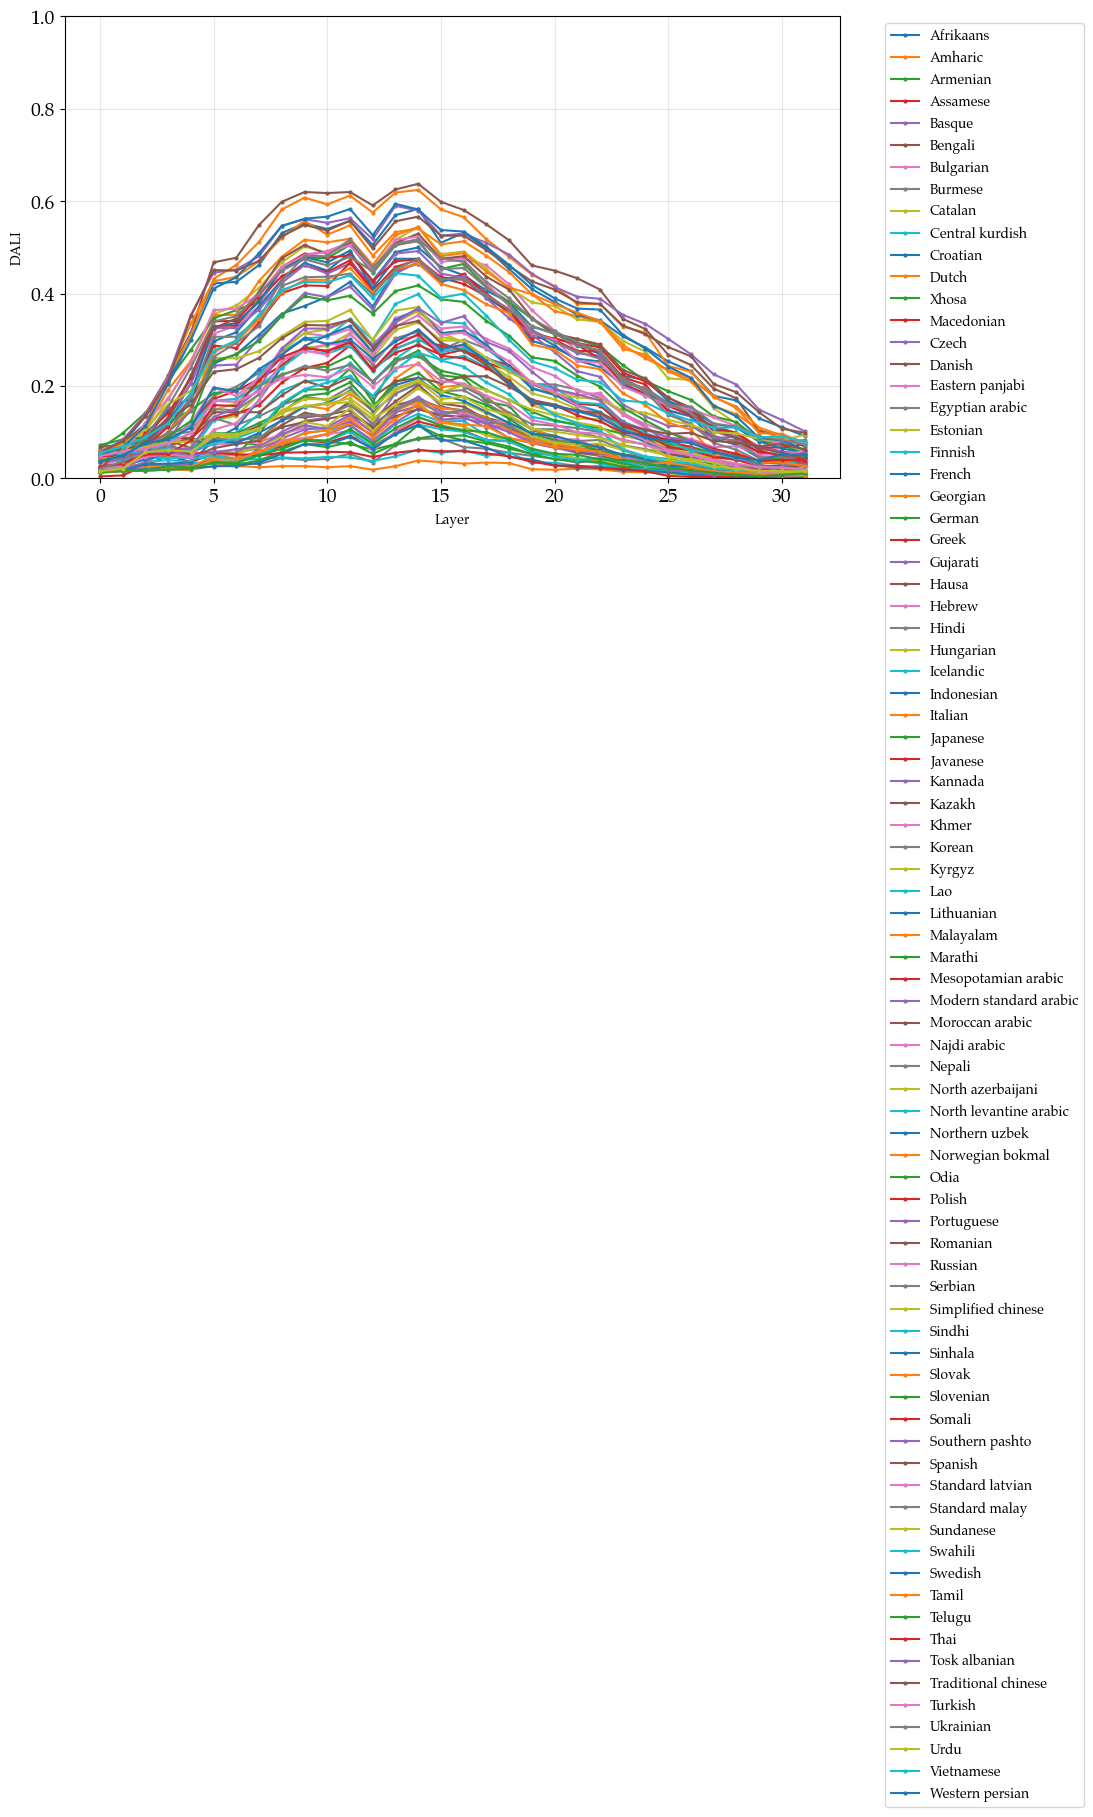

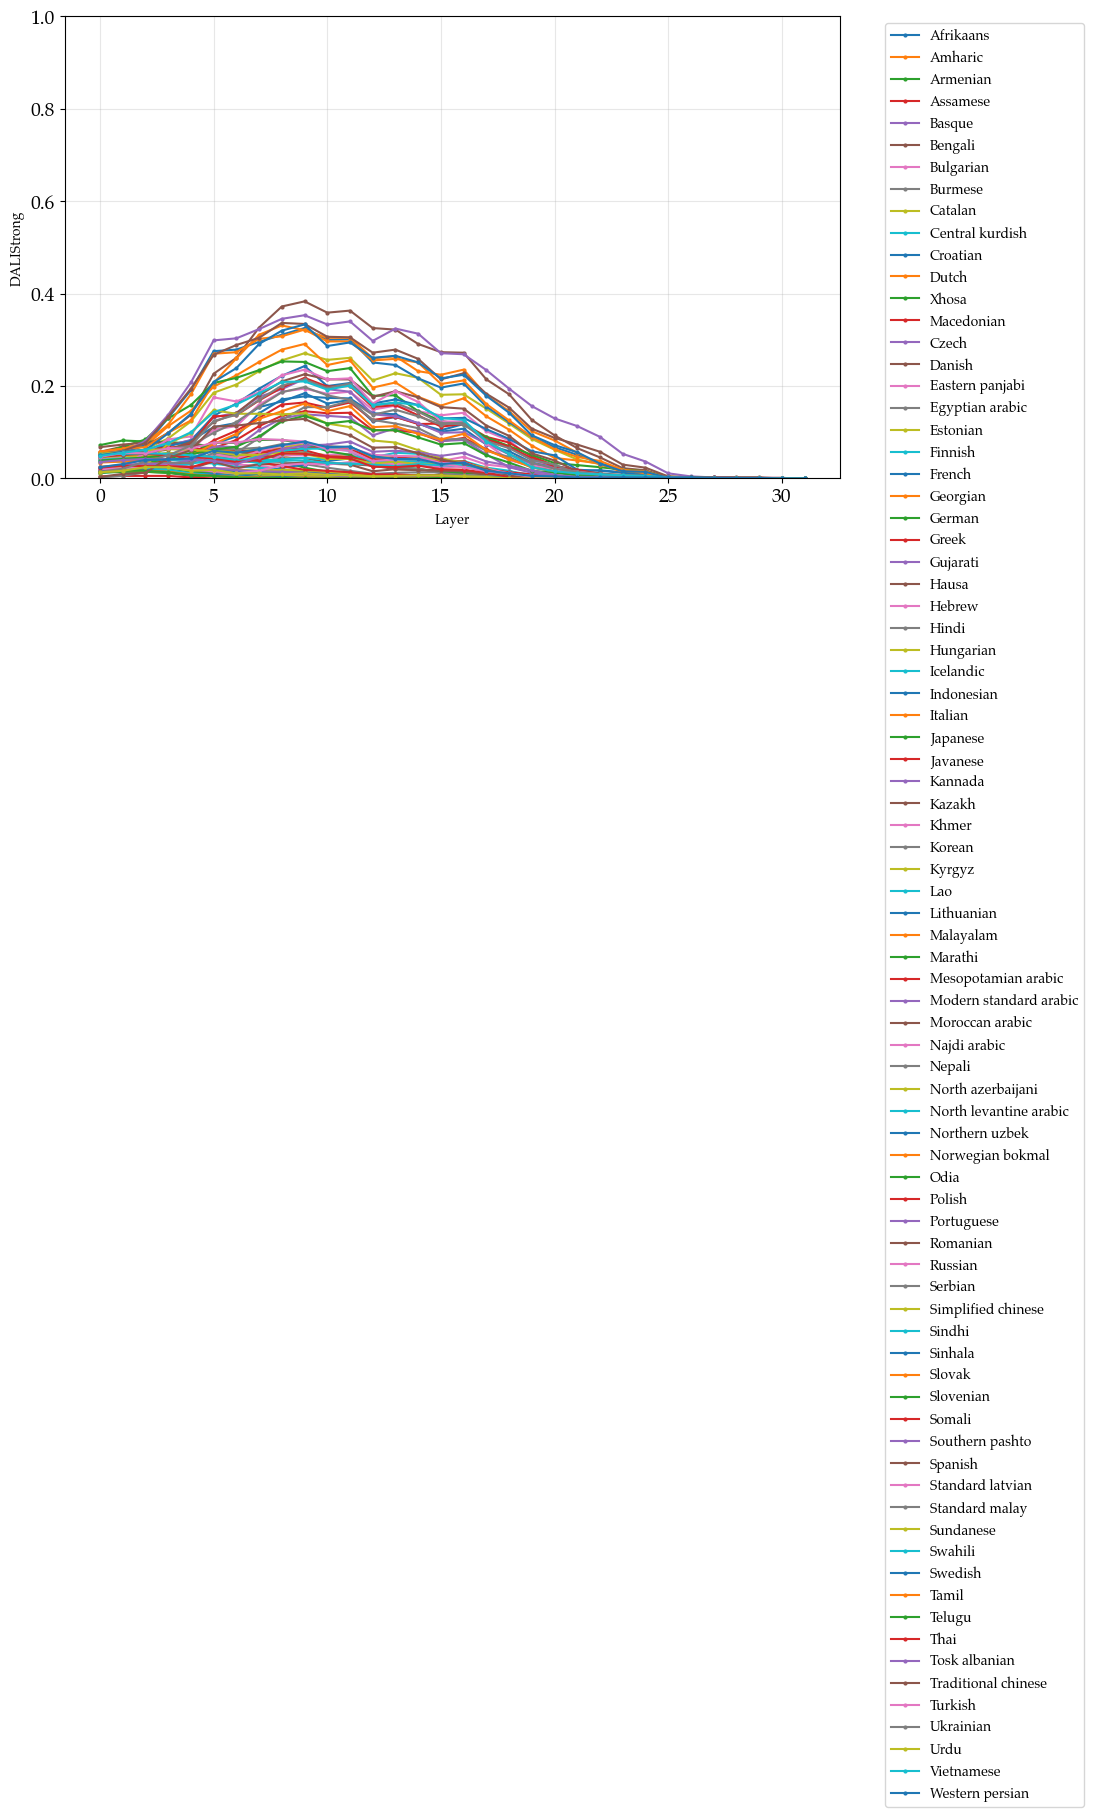

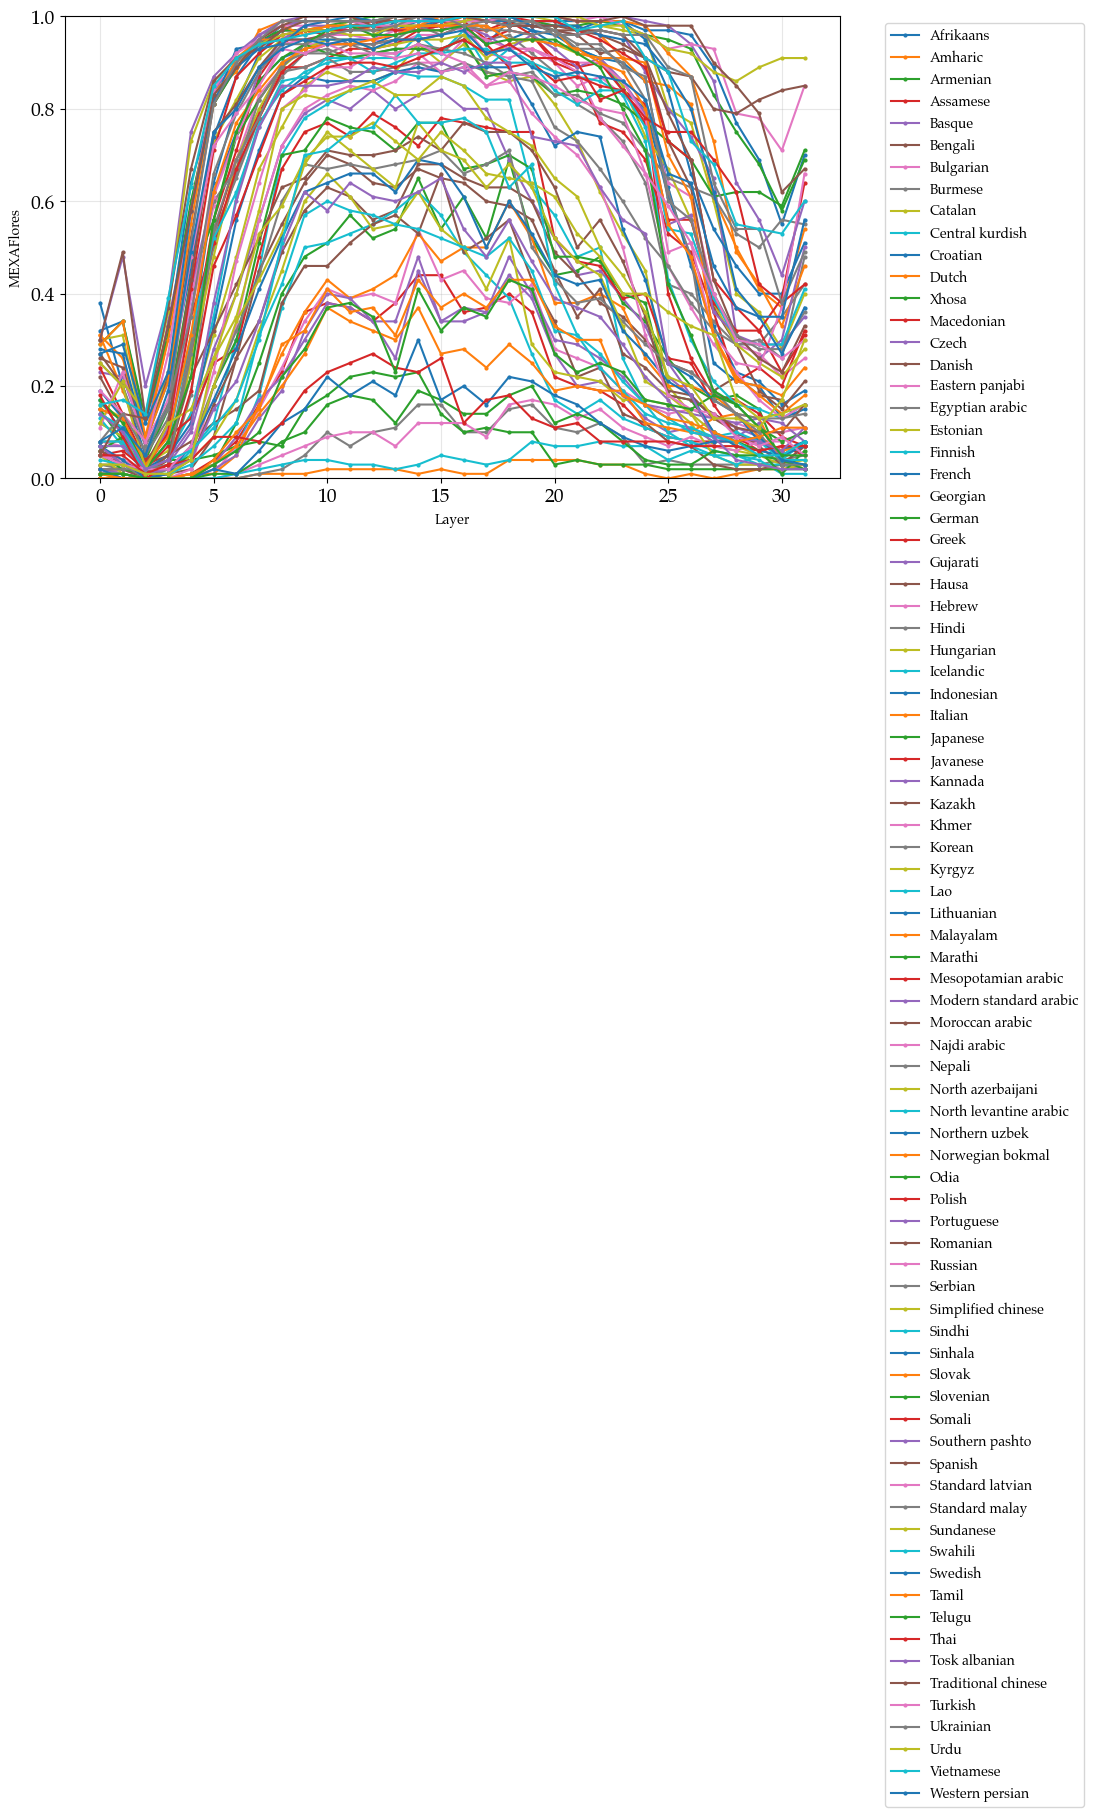

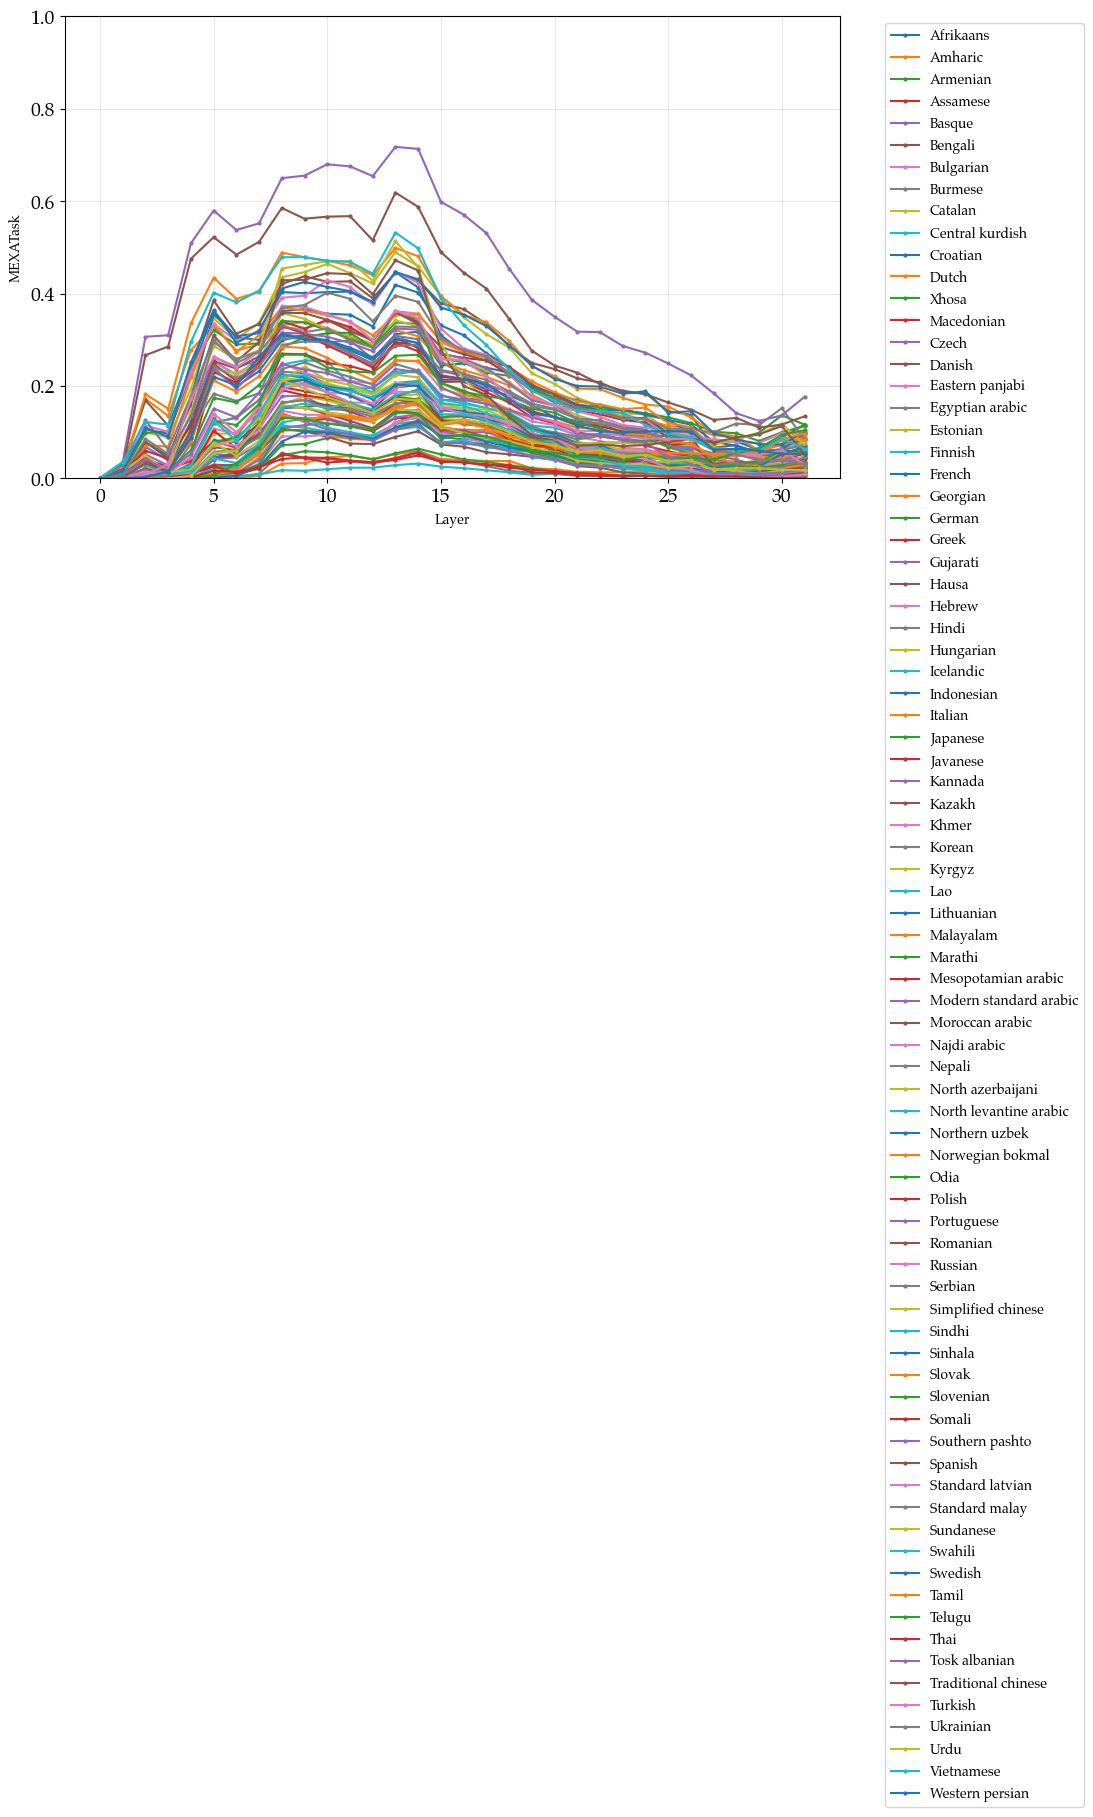

In [14]:
accuracies, maxpooled_dali_scores, meanpooled_dali_scores = plot_alignment_by_layers('DALI')
accuracies, maxpooled_dalistrong_scores, meanpooled_dalistrong_scores= plot_alignment_by_layers('DALIStrong')
accuracies, maxpooled_mexaflores_scores, meanpooled_mexaflores_scores = plot_alignment_by_layers('MEXAFlores')
accuracies, maxpooled_mexadataset_scores, meanpooled_mexadataset_scores = plot_alignment_by_layers('MEXATask')

In [ ]:
plot_ranked_correlation(entoxx_dataset_agg, 
                        xxtoen_dataset_agg, 
                        entoxx_flores_agg, 
                        xxtoen_flores_agg, 
                        accuracies, 
                        maxpooled_dali_scores, 
                        maxpooled_dalistrong_scores,
                        maxpooled_mexaflores_scores,
                        maxpooled_mexadataset_scores,
                        mode='alignment-translation',
                        subgroup="All")

In [15]:
def plot_pearson_correlation(entoxx_dataset_agg, 
                            xxtoen_dataset_agg, 
                            entoxx_flores_agg, 
                            xxtoen_flores_agg,
                            accuracies,
                            dali,
                            dali_strong,
                            mexa_flores,
                            mexa_dataset,
                            mode = "translation-accuracy",
                            subgroup="All"):
    
    if subgroup=="All":
        lang_list = LANGUAGE_wo_ENGLISH
    if subgroup=="HR":
        lang_list = [k for k,v in LANG_DICT.items() if v in HR_LANG]
    if subgroup=="LR":
        lang_list = [k for k,v in LANG_DICT.items() if v in LR_LANG]
    
    accuracies = [accuracies[lang] for lang in lang_list]
    entoxx_flores = [entoxx_flores_agg[lang] for lang in lang_list]
    xxtoen_flores = [xxtoen_flores_agg[lang] for lang in lang_list]
    entoxx_dataset = [entoxx_dataset_agg[lang] for lang in lang_list]
    xxtoen_dataset = [xxtoen_dataset_agg[lang] for lang in lang_list]
    dali = [dali[lang] for lang in lang_list]
    dali_strong = [dali_strong[lang] for lang in lang_list]
    mexa_flores = [mexa_flores[lang] for lang in lang_list]
    mexa_dataset = [mexa_dataset[lang] for lang in lang_list]
    

    if mode == "translation-accuracy":    
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        corr_entoxx_flores_acc, _ = pearsonr(entoxx_flores, accuracies)
        corr_xxtoen_flores_acc, _ = pearsonr(xxtoen_flores, accuracies)
        corr_entoxx_dataset_acc, _ = pearsonr(entoxx_dataset, accuracies)
        corr_xxtoen_dataset_acc, _ = pearsonr(xxtoen_dataset, accuracies)

        slope_entoxx_flores_acc, b_entoxx_flores_acc = np.polyfit(entoxx_dataset, accuracies, 1)
        slope_xxtoen_flores_acc, b_xxtoen_flores_acc = np.polyfit(xxtoen_dataset, accuracies, 1)
        slope_entoxx_dataset_acc, b_entoxx_dataset_acc = np.polyfit(entoxx_dataset, accuracies, 1)
        slope_xxtoen_dataset_acc, b_xxtoen_dataset_acc = np.polyfit(xxtoen_dataset, accuracies, 1)
        

        axes[0][0].scatter(entoxx_flores, accuracies, alpha=0.7, color='blue')
        axes[0][0].plot(entoxx_flores, np.array(entoxx_flores) * slope_entoxx_flores_acc + b_entoxx_flores_acc, color='red', label=f'Linear fit: y={slope_entoxx_flores_acc:.2f}x+{b_entoxx_flores_acc:.2f}')
        axes[0][0].text(0.3,0.7, f'Pearson r: {corr_entoxx_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('COMET Flores (En->XX)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'En->XX Flores COMET vs Accuracy')
        axes[0][0].set_xlim(0,1)
        axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(xxtoen_flores, accuracies, alpha=0.7, color='teal')
        axes[0][1].plot(xxtoen_flores, np.array(xxtoen_flores) * slope_xxtoen_flores_acc + b_xxtoen_flores_acc, color='red', label=f'Linear fit: y={slope_xxtoen_flores_acc:.2f}x+{b_xxtoen_flores_acc:.2f}')
        axes[0][1].text(0.3,0.7, f'Pearson r: {corr_xxtoen_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('COMET Flores (XX->En)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'XX->En Flores COMET vs Accuracy')
        axes[0][1].set_xlim(0,1)
        axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(entoxx_dataset, accuracies, alpha=0.7, color='brown')
        axes[1][0].plot(entoxx_dataset, np.array(entoxx_dataset) * slope_entoxx_dataset_acc + b_entoxx_dataset_acc, color='red', label=f'Linear fit: y={slope_entoxx_dataset_acc:.2f}x+{b_entoxx_dataset_acc:.2f}')
        axes[1][0].text(0.3,0.7, f'Pearson r: {corr_entoxx_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('COMET Dataset (En->XX)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'En->XX Dataset COMET vs Accuracy')
        axes[1][0].set_xlim(0,1)
        axes[1][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(xxtoen_dataset, accuracies, alpha=0.7, color='green')
        axes[1][1].plot(xxtoen_dataset, np.array(xxtoen_dataset) * slope_xxtoen_dataset_acc + b_xxtoen_dataset_acc, color='red', label=f'Linear fit: y={slope_xxtoen_dataset_acc:.2f}x+{b_xxtoen_dataset_acc:.2f}')
        axes[1][1].text(0.3,0.7, f'Pearson r: {corr_xxtoen_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('COMET Dataset (XX->En)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'XX->En Dataset COMET vs Accuracy')
        axes[1][1].set_xlim(0,1)
        axes[1][1].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Pearson Correlation: Translation Quality vs Accuracy in Belebele')
        plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/correl_translationquality_vs_accuracy_{subgroup}')
        #plt.show()

    if mode == "alignment-translation":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        corr_entoxx_task_mexa, _ = pearsonr(mexa_dataset, entoxx_dataset)
        corr_xxtoen_task_mexa, _ = pearsonr(mexa_dataset, xxtoen_dataset)
        corr_entoxx_flores_mexa, _ = pearsonr(mexa_flores, entoxx_flores)
        corr_xxtoen_flores_mexa, _ = pearsonr(mexa_flores, xxtoen_flores)
        


        slope_entoxx_task_mexa, b_entoxx_task_mexa = np.polyfit(mexa_dataset, entoxx_dataset, 1)
        slope_xxtoen_task_mexa, b_xxtoen_task_mexa = np.polyfit(mexa_dataset, xxtoen_dataset, 1)

        slope_entoxx_flores_mexa, b_entoxx_flores_mexa = np.polyfit(mexa_flores, entoxx_flores, 1)
        slope_xxtoen_flores_mexa, b_xxtoen_flores_mexa = np.polyfit(mexa_flores, xxtoen_flores, 1)

        axes[0][0].scatter(mexa_dataset, entoxx_dataset, alpha=0.7, color='blue')
        axes[0][0].plot(entoxx_dataset, np.array(entoxx_dataset) * slope_entoxx_task_mexa + b_entoxx_task_mexa, color='red', label=f'Linear fit: y={slope_entoxx_task_mexa:.2f}x+{b_entoxx_task_mexa:.2f}')
        axes[0][0].text(0.3,0.7, f'Pearson r: {corr_entoxx_task_mexa:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('MEXA Task')
        axes[0][0].set_ylabel('En->XX Premise COMET')
        axes[0][0].set_title(f'MEXA Task vs En->XX Premise')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(mexa_dataset, xxtoen_dataset, alpha=0.7, color='blue')
        axes[0][1].plot(xxtoen_dataset, np.array(xxtoen_dataset) * slope_xxtoen_task_mexa + b_xxtoen_task_mexa, color='red', label=f'Linear fit: y={slope_xxtoen_task_mexa:.2f}x+{b_xxtoen_task_mexa:.2f}')
        axes[0][1].text(0.3,0.7, f'Pearson r: {corr_xxtoen_task_mexa:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('MEXA Task')
        axes[0][1].set_ylabel('XX->En Premise COMET')
        axes[0][1].set_title(f'MEXA Task vs XX->En Premise')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(mexa_flores, entoxx_flores, alpha=0.7, color='blue')
        axes[1][0].plot(entoxx_flores, np.array(entoxx_flores) * slope_entoxx_flores_mexa + b_entoxx_flores_mexa, color='red', label=f'Linear fit: y={slope_entoxx_flores_mexa:.2f}x+{b_entoxx_flores_mexa:.2f}')
        axes[1][0].text(0.3,0.7, f'Pearson r: {corr_entoxx_flores_mexa:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('MEXA Flores')
        axes[1][0].set_ylabel('En->XX COMET')
        axes[1][0].set_title(f'MEXA Flores vs En->XX')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(mexa_flores, xxtoen_flores, alpha=0.7, color='blue')
        axes[1][1].plot(xxtoen_flores, np.array(xxtoen_flores) * slope_xxtoen_flores_mexa + b_xxtoen_flores_mexa, color='red', label=f'Linear fit: y={slope_xxtoen_flores_mexa:.2f}x+{b_xxtoen_flores_mexa:.2f}')
        axes[1][1].text(0.3, 0.7, f'Pearson r: {corr_xxtoen_flores_mexa:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('MEXA Flores')
        axes[1][1].set_ylabel('XX->En COMET')
        axes[1][1].set_title(f'MEXA Flores vs XX->En')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Correlation: MEXA vs Translation Quality in Belebele')
        
        plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/correl_mexa_vs_translationquality_{subgroup}')
        
        plt.show()

    if mode == "alignment-accuracy":
        # Calculate Pearson correlation coefficient
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        corr_dali_acc, _ = pearsonr(dali, accuracies)
        corr_dalistrong_acc, _ = pearsonr(dali_strong, accuracies)
        corr_mexaflores_acc, _ = pearsonr(mexa_flores, accuracies)
        corr_mexadataset_acc, _ = pearsonr(mexa_dataset, accuracies)

        slope_dali_acc, b_dali_acc = np.polyfit(dali, accuracies, 1)
        slope_dalistrong_acc, b_dalistrong_acc = np.polyfit(dali_strong, accuracies, 1)
        slope_mexaflores_acc, b_mexaflores_acc = np.polyfit(mexa_flores, accuracies, 1)
        slope_mexadataset_acc, b_mexadataset_acc = np.polyfit(mexa_dataset, accuracies, 1)

        axes[0][0].scatter(dali, accuracies, alpha=0.7, color='blue')
        axes[0][0].plot(dali, np.array(dali) * slope_dali_acc + b_dali_acc, color='red', label=f'Linear fit: y={slope_dali_acc:.2f}x+{b_dali_acc:.2f}')
        axes[0][0].text(0.3, 0.7, f'Pearson r: {corr_dali_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('DALI (Maxpool)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'DALI vs Accuracy')
        axes[0][0].set_xlim(0,1)
        axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(dali_strong, accuracies, alpha=0.7, color='teal')
        axes[0][1].plot(dali_strong, np.array(dali_strong) * slope_dalistrong_acc + b_dalistrong_acc, color='red', label=f'Linear fit: y={slope_dalistrong_acc:.2f}x+{b_dalistrong_acc:.2f}')
        axes[0][1].text(0.3, 0.7, f'Pearson r: {corr_dalistrong_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('DALIStrong (Maxpool)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'DALIStrong vs Accuracy')
        axes[0][1].set_xlim(0,1)
        axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(mexa_flores, accuracies, alpha=0.7, color='brown')
        axes[1][0].plot(mexa_flores, np.array(mexa_flores) * slope_mexaflores_acc + b_mexaflores_acc, color='red', label=f'Linear fit: y={slope_mexaflores_acc:.2f}x+{b_mexaflores_acc:.2f}')
        axes[1][0].text(0.3, 0.7, f'Pearson r: {corr_mexaflores_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('MEXA Flores (Maxpool)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'MEXA Flores vs Accuracy')
        axes[1][0].set_xlim(0,1)
        axes[1][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(mexa_dataset, accuracies, alpha=0.7, color='green')
        axes[1][1].plot(mexa_dataset, np.array(mexa_dataset) * slope_mexadataset_acc + b_mexadataset_acc, color='red', label=f'Linear fit: y={slope_mexadataset_acc:.2f}x+{b_mexadataset_acc:.2f}')
        axes[1][1].text(0.3, 0.7, f'Pearson r: {corr_mexadataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('MEXA Dataset (Maxpool)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'MEXA Dataset vs Accuracy')
        axes[1][1].set_xlim(0,1)
        axes[1][1].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)
    
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Pearson Correlation: Cross-Lingual Alignment vs Accuracy in Belebele')
        plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/correl_alignment_vs_accuracy_{subgroup}')
        plt.show()

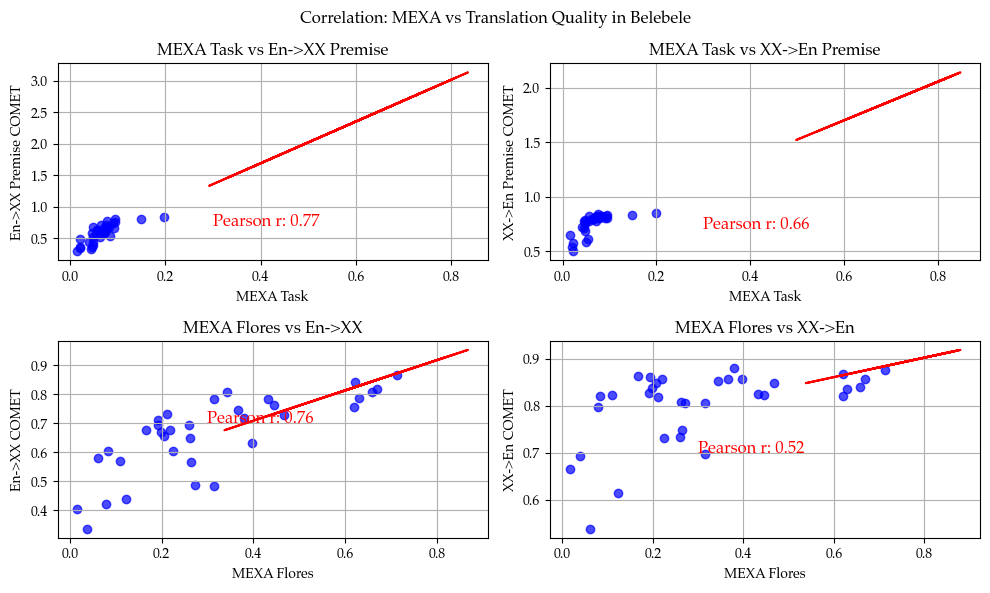

In [21]:
plot_pearson_correlation(entoxx_dataset_agg, 
                        xxtoen_dataset_agg, 
                        entoxx_flores_agg, 
                        xxtoen_flores_agg, 
                        accuracies, 
                        meanpooled_dali_scores, 
                        meanpooled_dalistrong_scores,
                        meanpooled_mexaflores_scores,
                        meanpooled_mexadataset_scores,
                        mode='alignment-translation',
                        subgroup="LR")

In [22]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE_wo_ENGLISH}
delta_dict = defaultdict(dict)



# Create a figure with subplots (2 rows, 5 columns)
#fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Flatten axes for easier iteration
#axes = axes.flatten()

for idx, lang in enumerate(LANGUAGE_wo_ENGLISH):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('belebele', lang, 'Llama3.1', mode='DALI')
    lang_DAS = {int(outer_k)-1: {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
    
    
    
                
     
    # Calculate averages for both cases
    all_list = defaultdict(list)
    cc_list = defaultdict(list)
    cw_list = defaultdict(list)
    wc_list = defaultdict(list)
    ww_list = defaultdict(list)

    for item in range(900):
        for layer in range(32):
            all_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            cc_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            cw_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_correct_lang_ids:
        for layer in range(32):
            wc_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_incorrect_lang_ids:
        for layer in range(32):
            ww_list[layer].append(lang_DAS[item][layer])
    
        
    all_mean = []
    cc_mean = []
    cw_mean = []
    ww_mean = []
    wc_mean = []

    for k,v in all_list.items():
        all_mean.append(np.mean(v))

    for k,v in cc_list.items():
        cc_mean.append(np.mean(v))

    for k,v in cw_list.items():
        cw_mean.append(np.mean(v))

    for k,v in ww_list.items():
        ww_mean.append(np.mean(v))

    for k,v in wc_list.items():
        wc_mean.append(np.mean(v))

    
    max_idx = np.argmax(all_mean)
    count = [np.sum(cc_list[max_idx]), np.sum(cw_list[max_idx])]
    nobs = [len(cc_list[max_idx]), len(cw_list[max_idx])]
    stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
    annotation_text = f'Δ: {cc_mean[max_idx]-cw_mean[max_idx]:.3f}\np-value: {pval:.3f}'
    #ax.annotate(annotation_text, xy=(0.7, 0.8), xycoords='axes fraction', fontsize=8,
                #bbox=dict(facecolor='white', alpha=0.5))
    delta_dict[lang]['delta'] = cc_mean[max_idx]-cw_mean[max_idx]
    delta_dict[lang]['pval'] = pval
    delta_dict[lang]['layer'] = max_idx
    delta_dict[lang]['n_cc'] = len(cc_list[max_idx])
    delta_dict[lang]['n_cw'] = len(cw_list[max_idx])



    # Plot lines for this language
    layers = list(range(32))
    #ax.plot(layers, [cc_mean[l] for l in layers], 
            #label='CC', marker='o', color='green', markersize=1)
    #ax.plot(layers, [cw_mean[l] for l in layers], 
            #label='CW', color = 'red', marker='o', markersize=1)
    #ax.plot(layers, [ww_mean[l] for l in layers], 
    #        label='WW', color = 'teal', marker='o', markersize=1)
    #ax.plot(layers, [wc_mean[l] for l in layers], 
    #        label='WC', color = 'magenta', marker='o', markersize=1)
    
    
    #ax.set_ylim(0,1)
    
    # Add title with accuracy
    #ax.set_title(f'{lang.capitalize()}')
    #ax.set_title(f'{lang.capitalize()}\nAccuracy: {accuracies[lang]:.1f}%')
    #ax.grid(True, alpha=0.3)
    #ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    #if idx >= 5:  # Bottom row
    #    ax.set_xlabel('Layer')
    #if idx % 5 == 0:  # Leftmost column
    #    ax.set_ylabel('% DALI')
    
    # Add legend only for the first subplot
    #if idx == 0:
    #    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')


#plt.tight_layout()
#plt.show()


# Sort by value
# Convert values to percentage
#data_percent = {lang: val * 100 for lang, val in delta_dict.items()}
#sorted_data = dict(sorted(data_percent.items(), key=lambda x: x[1]))

# Plots
#plt.figure(figsize=(12, 12))
#sns.barplot(x=list(sorted_data.values()), y=[LANG_DICT[item] for item in sorted_data.keys()], palette="coolwarm")

# Labels
#plt.xlabel("Δ DALI Strong % ", fontsize=12)
#plt.ylabel("Language", fontsize=12)
#plt.title("Sample Level Analysis")

# Add a grid
#plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/dalistrong_delta_cohortlevel')
#plt.show()

In [23]:
dali_delta_df = pd.DataFrame.from_dict(delta_dict, orient="index").reset_index()
dali_delta_df.rename(columns={'index': 'Language', 
                                 'delta': 'Delta', 
                                 'pval': 'pval', 
                                 'layer': 'layer', 
                                 'n_cc': 'n_cc', 
                                 'n_cw': 'n_cw'}, inplace=True)
dali_delta_df.to_excel("../../../../Images_DALI/belebele_plots/instance_level_dali_delta.xlsx", index=False)

In [24]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE_wo_ENGLISH}
delta_dict = defaultdict(dict)



# Create a figure with subplots (2 rows, 5 columns)
#fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Flatten axes for easier iteration
#axes = axes.flatten()

for idx, lang in enumerate(LANGUAGE_wo_ENGLISH):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('belebele', lang, 'Llama3.1', mode='DALIStrong')
    lang_DAS = {int(outer_k)-1: {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
    
    
    
                
     
    # Calculate averages for both cases
    all_list = defaultdict(list)
    cc_list = defaultdict(list)
    cw_list = defaultdict(list)
    wc_list = defaultdict(list)
    ww_list = defaultdict(list)

    for item in range(900):
        for layer in range(32):
            all_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            cc_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            cw_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_correct_lang_ids:
        for layer in range(32):
            wc_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_incorrect_lang_ids:
        for layer in range(32):
            ww_list[layer].append(lang_DAS[item][layer])
    
        
    all_mean = []
    cc_mean = []
    cw_mean = []
    ww_mean = []
    wc_mean = []

    for k,v in all_list.items():
        all_mean.append(np.mean(v))

    for k,v in cc_list.items():
        cc_mean.append(np.mean(v))

    for k,v in cw_list.items():
        cw_mean.append(np.mean(v))

    for k,v in ww_list.items():
        ww_mean.append(np.mean(v))

    for k,v in wc_list.items():
        wc_mean.append(np.mean(v))

    
    max_idx = np.argmax(all_mean)
    count = [np.sum(cc_list[max_idx]), np.sum(cw_list[max_idx])]
    nobs = [len(cc_list[max_idx]), len(cw_list[max_idx])]
    stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
    annotation_text = f'Δ: {cc_mean[max_idx]-cw_mean[max_idx]:.3f}\np-value: {pval:.3f}'
    #ax.annotate(annotation_text, xy=(0.7, 0.8), xycoords='axes fraction', fontsize=8,
                #bbox=dict(facecolor='white', alpha=0.5))
    delta_dict[lang]['delta'] = cc_mean[max_idx]-cw_mean[max_idx]
    delta_dict[lang]['pval'] = pval
    delta_dict[lang]['layer'] = max_idx
    delta_dict[lang]['n_cc'] = len(cc_list[max_idx])
    delta_dict[lang]['n_cw'] = len(cw_list[max_idx])



    # Plot lines for this language
    layers = list(range(32))
    #ax.plot(layers, [cc_mean[l] for l in layers], 
            #label='CC', marker='o', color='green', markersize=1)
    #ax.plot(layers, [cw_mean[l] for l in layers], 
            #label='CW', color = 'red', marker='o', markersize=1)
    #ax.plot(layers, [ww_mean[l] for l in layers], 
    #        label='WW', color = 'teal', marker='o', markersize=1)
    #ax.plot(layers, [wc_mean[l] for l in layers], 
    #        label='WC', color = 'magenta', marker='o', markersize=1)
    
    
    #ax.set_ylim(0,1)
    
    # Add title with accuracy
    #ax.set_title(f'{lang.capitalize()}')
    #ax.set_title(f'{lang.capitalize()}\nAccuracy: {accuracies[lang]:.1f}%')
    #ax.grid(True, alpha=0.3)
    #ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    #if idx >= 5:  # Bottom row
    #    ax.set_xlabel('Layer')
    #if idx % 5 == 0:  # Leftmost column
    #    ax.set_ylabel('% DALI')
    
    # Add legend only for the first subplot
    #if idx == 0:
    #    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')


#plt.tight_layout()
#plt.show()


# Sort by value
# Convert values to percentage
#data_percent = {lang: val * 100 for lang, val in delta_dict.items()}
#sorted_data = dict(sorted(data_percent.items(), key=lambda x: x[1]))

# Plots
#plt.figure(figsize=(12, 12))
#sns.barplot(x=list(sorted_data.values()), y=[LANG_DICT[item] for item in sorted_data.keys()], palette="coolwarm")

# Labels
#plt.xlabel("Δ DALI Strong % ", fontsize=12)
#plt.ylabel("Language", fontsize=12)
#plt.title("Sample Level Analysis")

# Add a grid
#plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/dalistrong_delta_cohortlevel')
#plt.show()

In [25]:
dalistrong_delta_df = pd.DataFrame.from_dict(delta_dict, orient="index").reset_index()
dalistrong_delta_df.rename(columns={'index': 'Language', 
                                 'delta': 'Delta', 
                                 'pval': 'pval', 
                                 'layer': 'layer', 
                                 'n_cc': 'n_cc', 
                                 'n_cw': 'n_cw'}, inplace=True)
dalistrong_delta_df.to_excel("../../../../Images_DALI/belebele_plots/instance_level_dalistrong_delta.xlsx", index=False)

In [26]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE_wo_ENGLISH}
delta_dict = defaultdict(dict)



# Create a figure with subplots (2 rows, 5 columns)
#fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Flatten axes for easier iteration
#axes = axes.flatten()

for idx, lang in enumerate(LANGUAGE_wo_ENGLISH):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('belebele', lang, 'Llama3.1', mode='MEXATask')
    lang_DAS = {int(k)-1: v for k,v in lang_DAS.items()}
    lang_DAS_formatted = defaultdict(dict)
    for layer in range(32):
        for i,dali in enumerate(lang_DAS[layer]):
            lang_DAS_formatted[i][layer] = lang_DAS[layer][i]
    
    
    
                
     
    # Calculate averages for both cases
    all_list = defaultdict(list)
    cc_list = defaultdict(list)
    cw_list = defaultdict(list)
    wc_list = defaultdict(list)
    ww_list = defaultdict(list)

    for item in range(900):
        for layer in range(32):
            all_list[layer].append(lang_DAS_formatted[item][layer])

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            cc_list[layer].append(lang_DAS_formatted[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            cw_list[layer].append(lang_DAS_formatted[item][layer])

    for item in incorrect_eng_correct_lang_ids:
        for layer in range(32):
            wc_list[layer].append(lang_DAS_formatted[item][layer])

    for item in incorrect_eng_incorrect_lang_ids:
        for layer in range(32):
            ww_list[layer].append(lang_DAS_formatted[item][layer])
    
        
    all_mean = []
    cc_mean = []
    cw_mean = []
    ww_mean = []
    wc_mean = []

    for k,v in all_list.items():
        all_mean.append(np.mean(v))

    for k,v in cc_list.items():
        cc_mean.append(np.mean(v))

    for k,v in cw_list.items():
        cw_mean.append(np.mean(v))

    for k,v in ww_list.items():
        ww_mean.append(np.mean(v))

    for k,v in wc_list.items():
        wc_mean.append(np.mean(v))

    
    max_idx = np.argmax(all_mean)
    count = [np.sum(cc_list[max_idx]), np.sum(cw_list[max_idx])]
    nobs = [len(cc_list[max_idx]), len(cw_list[max_idx])]
    stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
    annotation_text = f'Δ: {cc_mean[max_idx]-cw_mean[max_idx]:.3f}\np-value: {pval:.3f}'
    #ax.annotate(annotation_text, xy=(0.7, 0.8), xycoords='axes fraction', fontsize=8,
                #bbox=dict(facecolor='white', alpha=0.5))
    delta_dict[lang]['delta'] = cc_mean[max_idx]-cw_mean[max_idx]
    delta_dict[lang]['pval'] = pval
    delta_dict[lang]['layer'] = max_idx
    delta_dict[lang]['n_cc'] = len(cc_list[max_idx])
    delta_dict[lang]['n_cw'] = len(cw_list[max_idx])



    # Plot lines for this language
    layers = list(range(32))
    #ax.plot(layers, [cc_mean[l] for l in layers], 
            #label='CC', marker='o', color='green', markersize=1)
    #ax.plot(layers, [cw_mean[l] for l in layers], 
            #label='CW', color = 'red', marker='o', markersize=1)
    #ax.plot(layers, [ww_mean[l] for l in layers], 
    #        label='WW', color = 'teal', marker='o', markersize=1)
    #ax.plot(layers, [wc_mean[l] for l in layers], 
    #        label='WC', color = 'magenta', marker='o', markersize=1)
    
    
    #ax.set_ylim(0,1)
    
    # Add title with accuracy
    #ax.set_title(f'{lang.capitalize()}')
    #ax.set_title(f'{lang.capitalize()}\nAccuracy: {accuracies[lang]:.1f}%')
    #ax.grid(True, alpha=0.3)
    #ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    #if idx >= 5:  # Bottom row
    #    ax.set_xlabel('Layer')
    #if idx % 5 == 0:  # Leftmost column
    #    ax.set_ylabel('% DALI')
    
    # Add legend only for the first subplot
    #if idx == 0:
    #    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')


#plt.tight_layout()
#plt.show()


# Sort by value
# Convert values to percentage
#data_percent = {lang: val * 100 for lang, val in delta_dict.items()}
#sorted_data = dict(sorted(data_percent.items(), key=lambda x: x[1]))

# Plots
#plt.figure(figsize=(12, 12))
#sns.barplot(x=list(sorted_data.values()), y=[LANG_DICT[item] for item in sorted_data.keys()], palette="coolwarm")

# Labels
#plt.xlabel("Δ DALI Strong % ", fontsize=12)
#plt.ylabel("Language", fontsize=12)
#plt.title("Sample Level Analysis")

# Add a grid
#plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.savefig(fname=f'../../../../Images_DALI/belebele_plots/dalistrong_delta_cohortlevel')
#plt.show()

In [27]:
mexatask_delta_df = pd.DataFrame.from_dict(delta_dict, orient="index").reset_index()
mexatask_delta_df.rename(columns={'index': 'Language', 
                                 'delta': 'Delta', 
                                 'pval': 'pval', 
                                 'layer': 'layer', 
                                 'n_cc': 'n_cc', 
                                 'n_cw': 'n_cw'}, inplace=True)
mexatask_delta_df.to_excel("../../../../Images_DALI/belebele_plots/instance_level_mexatask_delta.xlsx", index=False)

In [ ]:
input_fields_list = ['flores_passage']
entoxx_sample = defaultdict(dict)
xxtoen_sample = defaultdict(dict)

for field in input_fields_list:
    entoxx, xxtoen = load_translation_sample('belebele', 'Llama3.1', field)
    for lang in LANGUAGE_wo_ENGLISH:
        entoxx_sample[field][lang] = entoxx[lang]['scores']
        xxtoen_sample[field][lang] = xxtoen[lang]['scores']



entoxx_mean_diff = defaultdict()
xxtoen_mean_diff = defaultdict()

for idx, lang in enumerate(LANGUAGE_wo_ENGLISH):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))
    
    entoxx_mean_diff[lang] = np.mean([entoxx_sample[field][lang][i] for i in correct_eng_correct_lang_ids]) - np.mean([entoxx_sample[field][lang][i] for i in correct_eng_incorrect_lang_ids]) 
    xxtoen_mean_diff[lang] = np.mean([xxtoen_sample[field][lang][i] for i in correct_eng_correct_lang_ids]) - np.mean([xxtoen_sample[field][lang][i] for i in correct_eng_incorrect_lang_ids]) 


In [ ]:
# Convert the dictionary to a DataFrame


# Sort by value
# Convert values to percentage

sorted_data = dict(sorted(entoxx_mean_diff.items(), key=lambda x: x[1]))

# Plots
plt.figure(figsize=(12, 12))
sns.barplot(x=list(sorted_data.values()), y=[LANG_DICT[item] for item in sorted_data.keys()], palette="coolwarm")

# Labels
plt.xlabel("Δ COMET En-XX", fontsize=12)
plt.ylabel("Language", fontsize=12)
#plt.title("Sample Level Analysis")

# Add a grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()